できるだけ簡素なtransformerを定義したい  
事前学習モデルの一部を使って重みは初期化。  
事前学習から行い、８クラス分類にヘッドを変えることで実現する  
  
### 今回は事前学習タスクであるマスク推測ができて学習ができていそうだったら成功とする  
->途中

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertModel, BertConfig

import utils

# For reproducibility
np.random.seed(42)
torch.manual_seed(42) # 乱数生成シード
cudnn.benchmark = True

# Grab a GPU if there is one
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using {} device: {}".format(device, torch.cuda.current_device()))
else:
    device = torch.device("cpu")
    print("Using {}".format(device))

Using cuda device: 0


In [23]:
from transformers import BertConfig, BertModel, BertForMaskedLM

# BERTの設定を定義
config = BertConfig(
    vocab_size=10522,  # あなたの語彙サイズ
    hidden_size=768,
    num_hidden_layers=12,
    num_attention_heads=12,
    intermediate_size=3072,
    max_position_embeddings=501,  # シーケンス長 + 1 (CLSトークン
)

# BERTモデルの初期化（重みはランダムに初期化される）
model = BertForMaskedLM(config)
print(model)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(10522, 768, padding_idx=0)
      (position_embeddings): Embedding(501, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [24]:
import torch
import torch.nn as nn

# カスタム埋め込み層を定義
class CustomBertEmbeddings(nn.Module):
    def __init__(self, config):
        super(CustomBertEmbeddings, self).__init__()
        self.word_embeddings = nn.Embedding(config.vocab_size, config.hidden_size)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.token_type_embeddings = nn.Embedding(config.type_vocab_size, config.hidden_size)
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, input_ids, token_type_ids=None, position_ids=None):
        if position_ids is None:
            position_ids = torch.arange(input_ids.size(1), dtype=torch.long, device=input_ids.device)
            position_ids = position_ids.unsqueeze(0).expand(input_ids.size(0), input_ids.size(1))
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)

        words_embeddings = self.word_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)
        token_type_embeddings = self.token_type_embeddings(token_type_ids)

        embeddings = words_embeddings + position_embeddings + token_type_embeddings
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

# モデルの埋め込み層をカスタム埋め込み層に置き換え
model.bert.embeddings = CustomBertEmbeddings(config)
print(model)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): CustomBertEmbeddings(
      (word_embeddings): Embedding(10522, 768)
      (position_embeddings): Embedding(501, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

# データ用意

In [7]:
import numpy as np
fold = "../../train_raw_npy/"
acc_x = np.loadtxt("../../train_raw/Acc_x.txt")
label = np.load(f"{fold}sampled_label.npy")

print(acc_x.shape)
print(label.shape)


(196072, 500)
(196072,)


sampled_acc_x: (5000000,)


c:\Users\kaiha\anaconda3\envs\labo_Okita\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


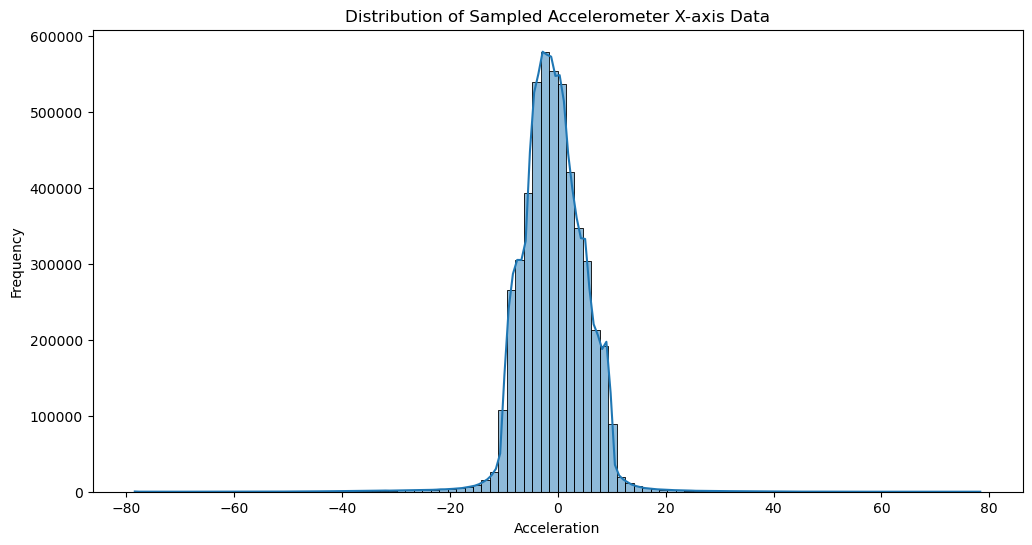

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# ランダムサンプリング
sample_size = 10000  # サンプルサイズを設定
indices = np.random.choice(acc_x.shape[0], size=sample_size, replace=False)
sampled_acc_x = acc_x[indices].flatten()  # フラット化して1次元配列にする
print("sampled_acc_x:", sampled_acc_x.shape)


# ヒストグラムとカーネル密度推定による分布の視覚化
plt.figure(figsize=(12, 6))
sns.histplot(sampled_acc_x, bins=100, kde=True)
plt.title("Distribution of Sampled Accelerometer X-axis Data")
plt.xlabel("Acceleration")
plt.ylabel("Frequency")
plt.show()

In [11]:
from sklearn.preprocessing import StandardScaler

# データを2Dに変換して標準化
scaler = StandardScaler()
x_reshaped = acc_x.reshape(-1, acc_x.shape[-1])  # (196072*3, 500
scaled_x = scaler.fit_transform(x_reshaped)  # 標準化
scaled_x = scaled_x.reshape(acc_x.shape)  # 元の形に戻す
print(scaled_x.shape)  # (196072, 3, 500)

(196072, 500)


sampled_acc_x: (5000000,)


c:\Users\kaiha\anaconda3\envs\labo_Okita\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


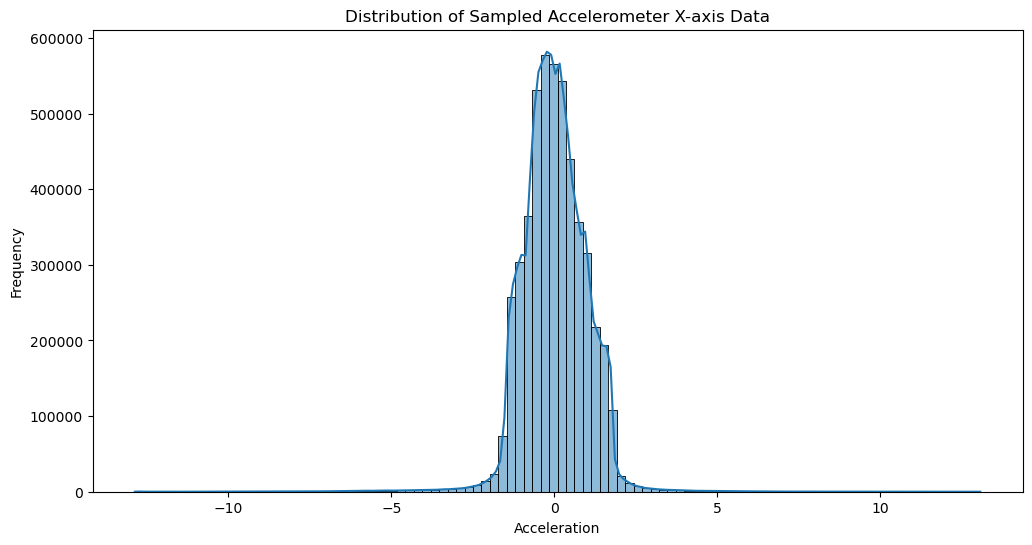

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# ランダムサンプリング
#sample_size = 10000  # サンプルサイズを設定
#indices = np.random.choice(acc_x.shape[0], size=sample_size, replace=False)
sampled_acc_x = scaled_x[indices].flatten()  # フラット化して1次元配列にする
print("sampled_acc_x:", sampled_acc_x.shape)


# ヒストグラムとカーネル密度推定による分布の視覚化
plt.figure(figsize=(12, 6))
sns.histplot(sampled_acc_x, bins=100, kde=True)
plt.title("Distribution of Sampled Accelerometer X-axis Data")
plt.xlabel("Acceleration")
plt.ylabel("Frequency")
plt.show()

## データは生データを等頻度ビニングとする
生値を等頻度ビニングする  
0~10521の範囲になるはず  
事前学習ではすべてのデータを対象にビニングするが、今はランダムのものだけを使っている。  
少しでも学習ができて精度が改善しそうであれば今回はよしとする

[[8391 8393 8407 ... 2157 2675 2907]
 [3063 3101 2689 ... 3153 3167 3118]
 [2935 2715 2423 ... 8795 8772 8829]
 ...
 [5590 5072 6628 ... 9121 7424 3197]
 [1313 4302 5615 ... 8046 8644 8336]
 [4451 4299 7482 ... 2594 4357 6225]]


c:\Users\kaiha\anaconda3\envs\labo_Okita\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


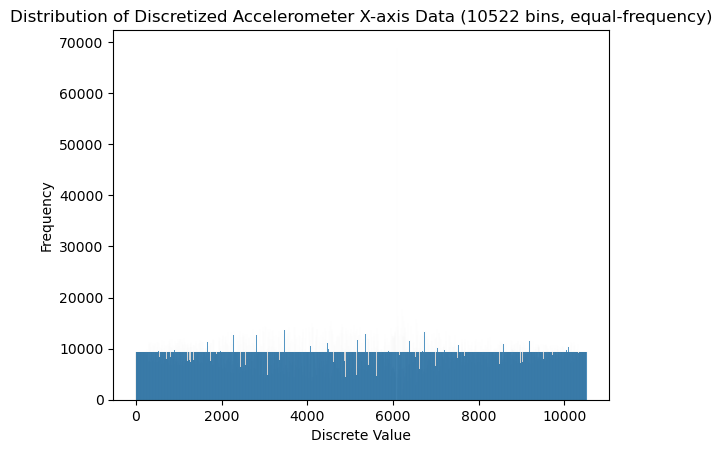

In [22]:
# ビンの数を設定
num_bins = 10522  # または 30522

# ビンの境界を等頻度で設定
bins = np.percentile(acc_x, np.linspace(0, 100, num_bins + 1))

# データをビンに分割
discrete_data = np.digitize(acc_x, bins) - 1  # ビンのインデックスを取得し、0から始まるように調整

# 離散化されたデータの一部を確認
print(discrete_data[:10])

# 離散化されたデータの分布を視覚化
#plt.figure(figsize=(12, 6))
sns.histplot(discrete_data.flatten(), bins=num_bins, kde=False)
plt.title(f"Distribution of Discretized Accelerometer X-axis Data ({num_bins} bins, equal-frequency)")
plt.xlabel("Discrete Value")
plt.ylabel("Frequency")
plt.show()